**Training environment for RNN in Neuroscience**

Plan for this notebook :
* Function that solve the differential equation using RK4 to plot RNN behaviors
* Function that generate fake data for training purposes
* Function that does the training
* Function to compute the loss
* Examples

### RNN Behaviors

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
def dydx(t,x,W, sigma, mu):
    '''Differential equation'''
    return -x + sigma(W @ x - mu)

def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):
    '''Approximate RNN behaviors using RK4 numerical method
    -----------------------
    t : np.linspace()
        Time array
    IC : Line vector
        Initial condition
    dydx : Function
        Differential equation
    W : Matrix of shape (n_neuron x n_neuron)
        Weight matrix
    sigma : Function
        Activation function (sigmoid if unspecified)
    mu : float/int
        Activation threshold (0 if unspecified)
    ----------------------
    return result and dt
    '''
    n = len(IC)
    m = len(t)
    res = np.zeros((m, n))   #mxn matrix that contain our values
    res[0] = IC  # First line is redefine
    dt = (t[-1] - t[0])/m
    for i in range(1, m):
        k1 = dt * dydx(t[i-1], res[(i-1)], W=W, sigma=sigma, mu=mu)
        k2 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k1, W=W, sigma=sigma, mu=mu)
        k3 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k2, W=W, sigma=sigma, mu=mu)
        k4 = dt * dydx(t[i-1] + dt, res[(i-1)] + k3, W=W, sigma=sigma, mu=mu)
        res[i] = res[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return res, dt

### Generate Data

In [22]:
def GenerateData(n_data, time, IC, W, ratio=0.6, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):
    '''
    Generate fake data that follow a RNN function
    -------------------
    n_data : int
        Number of data per neuron
    time : float
        Time of our sample
    IC : Line 
        Initials conditions
    W : Square matrix with shape n_neurons x n_neurons
        Weight Matrix
    ratio : float or int ]0,1]
        Percentage of our fake data that will be use for training
    mu : float or int
        Activation threshold (0 if unspecified)
    sigma : function
        Non-linearities (sigmoid if unspecified)
    -------------------
    Return dict
    '''

    t = np.linspace(0, time, n_data)

    Slice = int(ratio * len(t))
    time_data = t[:Slice]
    Test_Data = np.array([])
    if ratio < 1:
        time_test = t[Slice:]
        Test_Data = rnn(t=time_test, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu).T

    Data, dt = rnn(t=time_data, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu)
    Data = Data.T

    out = {}
    out["Data"] = Data
    out["Test_Data"] = Test_Data
    out["W"] = W
    out["dt"] = dt
    out["mu"] = mu

    return out

### Training

We use the following equation to represent our behavior :

$\dot{\vec{x}} = -x+\sigma(Wx+\mu)$

With Euler, we have :

$x(t+\Delta t) = x(t) + \Delta x =  x(t)[1-\Delta t]+\sigma(Wx-\mu)\Delta t$

*Model*

In [5]:
class RNNModel(nn.Module):

    def __init__(self, W, dt, mu):
        super(RNNModel, self).__init__()
        self.W = W
        self.dt = dt
        self.mu = mu
    
    def forward(self, x):
        return x * (1-self.dt) + (torch.sigmoid(torch.matmul(self.W, x) - self.mu))*self.dt

In [43]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    W = torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        for i in range(x.shape[0]):
            if (i+1) == x.shape[0]:
                continue
            else:
                x_pred[i+1] = model(x[i])
        
        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out



### Example 2x2 matrix

epoch 0/1000 loss 0.002099
epoch 100/1000 loss 0.000017
epoch 200/1000 loss 0.000005
epoch 300/1000 loss 0.000002
epoch 400/1000 loss 0.000001
epoch 500/1000 loss 0.000001
epoch 600/1000 loss 0.000001
epoch 700/1000 loss 0.000000
epoch 800/1000 loss 0.000000
epoch 900/1000 loss 0.000000


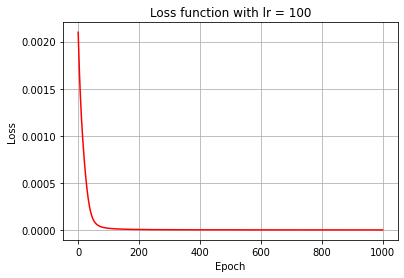

In [53]:
n=2
a = GenerateData(n_data=50, time=5, IC=np.random.rand(n), W=np.random.randn(n, n), ratio=1)

Prediction = Train_RNN(2, a["Data"].T, a["dt"], mu=a["mu"], n_iters=1000, lr=100, verbose=True, loss_graph=True)

W = Prediction["W"]

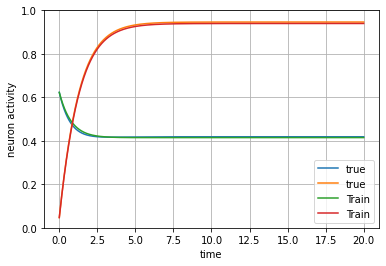

In [54]:
t = np.linspace(0, 20, 10000)
IC = (a["Data"].T)[0]

x_true = rnn(t=t, IC=IC, dydx=dydx, W=a["W"])[0]
#x_untrain = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W0"])[0]
x_train = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W"])[0]


plt.plot(t, x_true, label="true")
#plt.plot(t, x_untrain, label="Untrain")
plt.plot(t, x_train, label="Train")
plt.xlabel("time")
plt.ylabel("neuron activity")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

### Example 4x4 Matrix

epoch 0/2000 loss 0.000636
epoch 100/2000 loss 0.000498
epoch 200/2000 loss 0.000365
epoch 300/2000 loss 0.000244
epoch 400/2000 loss 0.000148
epoch 500/2000 loss 0.000084
epoch 600/2000 loss 0.000046
epoch 700/2000 loss 0.000025
epoch 800/2000 loss 0.000015
epoch 900/2000 loss 0.000009
epoch 1000/2000 loss 0.000006
epoch 1100/2000 loss 0.000005
epoch 1200/2000 loss 0.000004
epoch 1300/2000 loss 0.000004
epoch 1400/2000 loss 0.000003
epoch 1500/2000 loss 0.000003
epoch 1600/2000 loss 0.000003
epoch 1700/2000 loss 0.000003
epoch 1800/2000 loss 0.000003
epoch 1900/2000 loss 0.000003


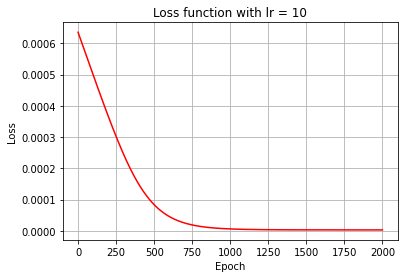

In [56]:
n=4
a = GenerateData(n_data=50, time=5, IC=np.random.rand(n), W=np.random.randn(n, n), ratio=1)

Prediction = Train_RNN(4, a["Data"].T, a["dt"], mu=a["mu"], n_iters=2000, lr=10, verbose=True, loss_graph=True)


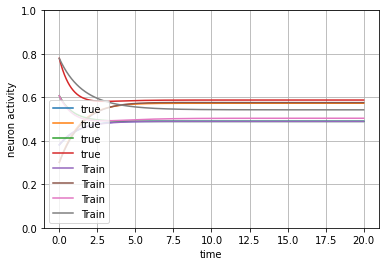

In [63]:
t = np.linspace(0, 20, 10000)
IC = (a["Data"].T)[0]

x_true = rnn(t=t, IC=IC, dydx=dydx, W=a["W"])[0]
#x_untrain = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W0"])[0]
x_train = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W"])[0]


plt.plot(t, x_true, label="true")
#plt.plot(t, x_untrain, label="Untrain")
plt.plot(t, x_train, label="Train")
plt.xlabel("time")
plt.ylabel("neuron activity")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

### Example 20 x 20

C:\Users\antho\AppData\Local\Temp/ipykernel_16660/1086228128.py:5: RuntimeWarning: overflow encountered in exp
  def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):


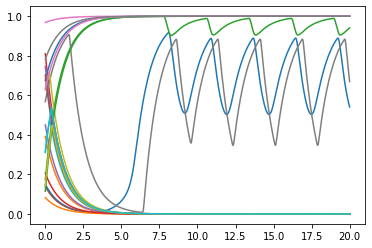

In [119]:
n=20
IC=np.random.rand(n)
a = GenerateData(n_data=50, time=5, IC=IC, W=100*np.random.randn(n, n), ratio=1)

W_true = a["W"]
t = np.linspace(0, 20, 1000)
plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=W_true)[0])
plt.show()  #See 7th neuron

epoch 0/25000 loss 0.002433
epoch 100/25000 loss 0.002388
epoch 200/25000 loss 0.002343
epoch 300/25000 loss 0.002300
epoch 400/25000 loss 0.002258
epoch 500/25000 loss 0.002218
epoch 600/25000 loss 0.002179
epoch 700/25000 loss 0.002142
epoch 800/25000 loss 0.002106
epoch 900/25000 loss 0.002072
epoch 1000/25000 loss 0.002040
epoch 1100/25000 loss 0.002009
epoch 1200/25000 loss 0.001979
epoch 1300/25000 loss 0.001951
epoch 1400/25000 loss 0.001924
epoch 1500/25000 loss 0.001897
epoch 1600/25000 loss 0.001872
epoch 1700/25000 loss 0.001848
epoch 1800/25000 loss 0.001824
epoch 1900/25000 loss 0.001801
epoch 2000/25000 loss 0.001779
epoch 2100/25000 loss 0.001757
epoch 2200/25000 loss 0.001735
epoch 2300/25000 loss 0.001714
epoch 2400/25000 loss 0.001693
epoch 2500/25000 loss 0.001672
epoch 2600/25000 loss 0.001652
epoch 2700/25000 loss 0.001631
epoch 2800/25000 loss 0.001611
epoch 2900/25000 loss 0.001590
epoch 3000/25000 loss 0.001570
epoch 3100/25000 loss 0.001549
epoch 3200/25000 los

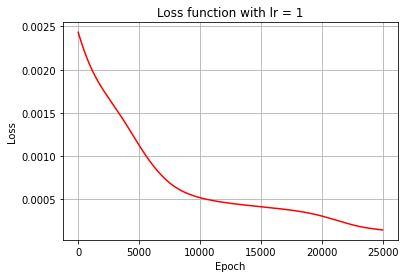

In [172]:
Prediction = Train_RNN(20, a["Data"].T, a["dt"], mu=a["mu"], n_iters=25000, lr=1, verbose=True, loss_graph=True)

When dealing with those types of neurons, we can see that neurons that tend to converge get trains really well. We can see how the 10th neurons is train :

C:\Users\antho\AppData\Local\Temp/ipykernel_16660/1086228128.py:5: RuntimeWarning: overflow encountered in exp
  def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):


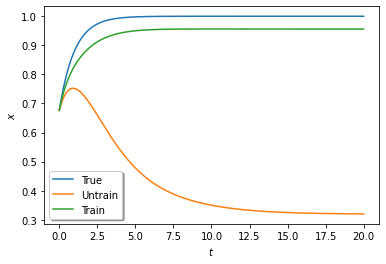

In [202]:
t = np.linspace(0, 20, 10000)
IC = (a["Data"].T)[0]

x_true = rnn(t=t, IC=IC, dydx=dydx, W=a["W"])[0]
x_untrain = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W0"])[0]
x_train = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W"])[0]

plt.plot(t, x_true[:,10], label="True")
plt.plot(t, x_untrain[:,10], label="Untrain")
plt.plot(t, x_train[:,10], label="Train")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.legend(shadow=True, fancybox=True)
plt.show()

We can see that when dealing with a neuron that has a oscillation behavior, the training tends to go to the average of the oscillation.

C:\Users\antho\AppData\Local\Temp/ipykernel_16660/1086228128.py:5: RuntimeWarning: overflow encountered in exp
  def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):


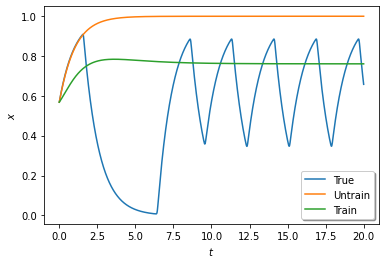

In [203]:
t = np.linspace(0, 20, 10000)
IC = (a["Data"].T)[0]

x_true = rnn(t=t, IC=IC, dydx=dydx, W=a["W"])[0]
x_untrain = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W0"])[0]
x_train = rnn(t=t, IC=IC, dydx=dydx, W=Prediction["W"])[0]

plt.plot(t, x_true[:,7], label="True")
plt.plot(t, x_untrain[:,7], label="Untrain")
plt.plot(t, x_train[:,7], label="Train")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.legend(shadow=True, fancybox=True)
plt.show()